In [6]:
import sys
sys.path.append('..')

import numpy as np

import tensorflow as tf
from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
import keras.backend as K

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random

from LineFilterLayer import LineFilterLayer

modelPath = 'model/BasicStrategyTwo.h5'

In [2]:
print(K.image_data_format()) 
# expected output: channels_last

channels_last


In [3]:
def dotsAndBoxesToCategorical(inputData):
    inp = np.copy(inputData)
    inp[inp == 255] = 1 # Line - comes first so that target data only has two categories
    inp[inp == 65] = 2 # Box A
    inp[inp == 150] = 3 # Box B
    inp[inp == 215] = 4 # Dot
    cat = to_categorical(inp)
    newShape = inp.shape + (cat.shape[-1],)
    return cat.reshape(newShape)

In [4]:
firstTryDataset = np.load('basicStrategy5x4.npz')
x_train = firstTryDataset['x_train']
y_train = firstTryDataset['y_train']
x_train_cat = dotsAndBoxesToCategorical(x_train)
y_train_cat = y_train[:,LineFilterLayer.lineFilterMatrix(x_train.shape[-1], x_train.shape[-2], True)]

np.set_printoptions(precision=2)

print("original data:")
print(x_train[0])
print(y_train[0])
print(x_train.shape)
print(y_train.shape)

print("\nnormalized data:")
print(np.transpose(x_train_cat[0]))
print(np.transpose(y_train_cat[0]))
print(x_train_cat.shape)
print(y_train_cat.shape)

original data:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215   0 215   0 215   0]
 [  0   0   0 255   0 255   0 255   0   0   0   0   0]
 [  0 215 255 215   0 215   0 215   0 215   0 215   0]
 [  0   0   0   0   0   0   0 255   0   0   0 255   0]
 [  0 215   0 215 255 215   0 215   0 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0 255   0   0   0]
 [  0 215   0 215   0 215   0 215 255 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215 255 215   0 215   0 215   0 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 255   0 255   0   0]
 [  0   0   0   0   0   0   0   0   0 255   0 255   0]
 [  0   0   0   0   0   0   0   0 255   0 255   0   0]
 [  0 255   0 255   0 255   0   0   0 255   0   0   0]
 [  0   0 255   0   0   0 255   0   0   0 255   0   0]
 [  0 255   0 255   0 255   0   0   0   0   0 255

In [9]:
# LineFilterLayer has to be set before loading the model
LineFilterLayer.imgWidth = x_train.shape[-1]
LineFilterLayer.imgHeight = x_train.shape[-2]

model = load_model(modelPath, custom_objects={'LineFilterLayer':LineFilterLayer})
#model.save(modelPath)

LineFilterLayer from_config!
{u'trainable': True, u'img_height': 11, u'name': u'line_filter_layer_1', u'img_width': 13}
Tensor("Const_1:0", shape=(11, 13), dtype=bool)
LineFilterLayer.build()
(None, None, None, 1)


In [5]:
img_input = Input(shape=(None,None,5,))
kernelSize = (5,5)
x = Conv2D(64, kernelSize, padding='same', activation='relu')(img_input)
x = BatchNormalization()(x)
x = Conv2D(64, kernelSize, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernelSize, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernelSize, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernelSize, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernelSize, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(1, kernelSize, padding='same')(x)
x = LineFilterLayer(x_train.shape[-1], x_train.shape[-2])(x)
x = Activation('sigmoid', name='sigmoid')(x)

model = Model(inputs=img_input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Tensor("Const:0", shape=(11, 13), dtype=bool)
LineFilterLayer.build()
(None, None, None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 5)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    8064      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 64)    256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    102464    
__________________________________________________

In [7]:
# Training
callbacks = []

checkpoint = ModelCheckpoint(filepath='model/BasicStrategyTwoCheckpoint.h5', save_weights_only=False)
callbacks.append(checkpoint)

progbar = ProgbarLogger()
callbacks.append(progbar)

tensorboard = TensorBoard(log_dir='model/log2', write_grads=True, write_graph=True, write_images=True, histogram_freq=1)
callbacks.append(tensorboard)

model.fit(x_train_cat, y_train_cat, epochs=10, batch_size=64, callbacks=callbacks, validation_split=0.001)

model.save(modelPath)

Train on 99900 samples, validate on 100 samples
Epoch 1/10
Epoch 1/10
99900/99900 [==============================] - 151s 2ms/step - loss: -795.1251 - val_loss: -1019.8718
Epoch 2/10
Epoch 2/10
99900/99900 [==============================] - 149s 1ms/step - loss: -799.3109 - val_loss: -1019.8411
Epoch 3/10
Epoch 3/10
99900/99900 [==============================] - 143s 1ms/step - loss: -799.3078 - val_loss: -1019.5048
Epoch 4/10
Epoch 4/10
99900/99900 [==============================] - 146s 1ms/step - loss: -799.3105 - val_loss: -1019.8767
Epoch 5/10
Epoch 5/10
99900/99900 [==============================] - 149s 1ms/step - loss: -799.3046 - val_loss: -1019.8765
Epoch 6/10
Epoch 6/10
99900/99900 [==============================] - 139s 1ms/step - loss: -799.3153 - val_loss: -1019.8767
Epoch 7/10
Epoch 7/10
99900/99900 [==============================] - 152s 2ms/step - loss: -799.3059 - val_loss: -1019.8767
Epoch 8/10
Epoch 8/10
99900/99900 [==============================] - 151s 2ms/step -

example: 59541
input: 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215 255 215   0 215 255 215 255 215   0 215   0]
 [  0 255  65 255   0   0   0   0   0 255   0 255   0]
 [  0 215 255 215 255 215 255 215   0 215   0 215   0]
 [  0 255  65 255  65 255  65 255   0   0   0 255   0]
 [  0 215 255 215 255 215 255 215 255 215 255 215   0]
 [  0 255 150 255  65 255  65 255 150 255   0 255   0]
 [  0 215 255 215 255 215 255 215 255 215   0 215   0]
 [  0 255 150 255 150 255 150 255 150 255   0   0   0]
 [  0 215 255 215 255 215 255 215 255 215 255 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]
prediction: 
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0

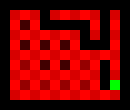

In [42]:
example = random.randrange(x_train.shape[0])
print("example: "+str(example))

input_data = x_train[example:example+1]
input_data_cat = x_train_cat[example:example+1]

prediction = model.predict(input_data_cat)

# print input data
input_data_print = x_train[example,:,:] 
input_data_print = input_data_print.astype(np.uint8)
print("input: ")
print(input_data_print)

# generate greyscale image data from input data
target_imgdata = x_train[example,:,:] 
target_imgdata = target_imgdata.astype(np.uint8)

# print prediction
prediction_data_print = prediction[0,:,:,1] * 100 
prediction_data_print = prediction_data_print.astype(np.uint8)
print("prediction: ")
print(prediction_data_print)

# generate greyscale image data from prediction data
prediction_imgdata = prediction[0] * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# merge image data in color channels
tmp = np.zeros((prediction[0].shape[0], prediction[0].shape[1]), dtype=np.uint8)
merged_imgdata = np.stack([target_imgdata, prediction_imgdata[:,:,1], tmp], axis=2)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img